# Proyecto 3 - Detección de líneas

- Daniel Rayo
- Nahomy Castro
- Xavier López
- Irving Acosta

### Instalación de CUDA

In [5]:
# Install CUDA C++ plugin for Colab:
!pip install nvcc4jupyter
# Install libpng development library
!apt-get update
!apt-get install -y libpng-dev

# Check CUDA installation
!nvcc --version
%load_ext nvcc4jupyter

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [6]:
# Install libpng development library
!apt-get update
!apt-get install -y libpng-dev

# Check CUDA installation
!nvcc --version# Dependencias
# !pip install opencv-python pillow

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://cli.github.com/packages stable InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [7]:
# Detect selected GPU and its NVIDA architecture:
import subprocess
gpu_info = subprocess.getoutput("nvidia-smi --query-gpu=name,compute_cap --format=csv,noheader,nounits")
if "not found" in gpu_info.lower(): raise RuntimeError("Error: No GPU found. Please select a GPU runtime environment.")
gpu_name, compute_cap = map(str.strip, gpu_info.split(','))
gpu_arch = f"sm_{compute_cap.replace('.', '')}"

print(f"{'GPU Name':<15}: {gpu_name}")
print(f"{'Architecture':<15}: {gpu_arch}")

GPU Name       : Tesla T4
Architecture   : sm_75


In [8]:
#!git clone --depth 1 https://github.com/DanielRasho/Paralela-proj3

## Funcionamiento del algoritmo

## Generacion de PGM

Para probar el algoritmo con diferentes tipos de entradas, a continuación se muestra el script utilizado para poder transformar imagenes corrientes en su versión pgm.

In [9]:
# EXECUTE JUST ONCE TO DOWNLOAD THE SOURCE IMAGES !!!!
!rm -rf ./media
!git clone --depth 1 https://github.com/opencv/opencv.git
!mkdir -p ./media/
!mkdir -p ./media/raw
!mkdir -p ./media/output
!cp -r opencv/samples/data/* ./media/raw
!rm -rf opencv
!rm -rf ./media/raw/aruco ./media/raw/dnn/

Cloning into 'opencv'...
remote: Enumerating objects: 9126, done.
remote: Counting objects: 100% (9126/9126), done.
remote: Compressing objects: 100% (7794/7794), done.
remote: Total 9126 (delta 1430), reused 4714 (delta 893), pack-reused 0 (from 0)
Receiving objects: 100% (9126/9126), 89.53 MiB | 19.44 MiB/s, done.
Resolving deltas: 100% (1430/1430), done.
Updating files: 100% (7664/7664), done.


In [10]:
# RUN JUST ONCE TO CONVERT IMAGES TO PGM FORMAT
import cv2
from pathlib import Path

input_dir = Path("./media/raw")
output_dir = Path("./media/pgm")
output_dir.mkdir(parents=True, exist_ok=True)

LOW_THRESH, HIGH_THRESH = 100, 200

# Gather only supported files
files = [f for f in input_dir.iterdir() if f.suffix.lower() in [".png", ".jpg", ".jpeg"]]

for i, file in enumerate(sorted(files)):
    img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read {file}, skipping.")
        continue

    blur = cv2.GaussianBlur(img, (3, 3), 0)
    edges = cv2.Canny(blur, LOW_THRESH, HIGH_THRESH)

    output_path = output_dir / f"{i}.pgm"
    cv2.imwrite(str(output_path), edges)

print("Finished processing all PNG/JPG images.")


🎉 Finished processing all PNG/JPG images.


Este es un ejemplo de las imagenes de entrada con las que se estuvo trabajando:

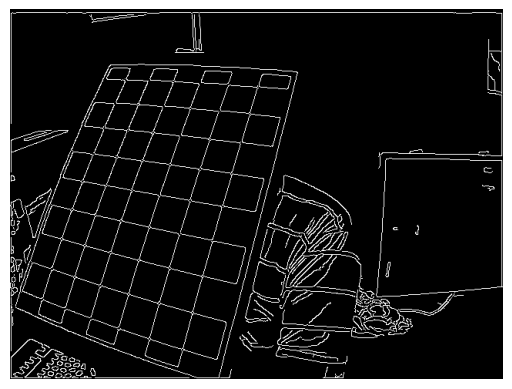

In [11]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./media/pgm/76.pgm", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

def show_comparison(input_path: str, output_path: str, name: str = None):
    original = Image.open(input_path)
    result = Image.open(output_path)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f'Original Image{": " + name if name else ""}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title(f'Detected Lines (Pink){": " + name if name else ""}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


## CPU

In [13]:
!nvcc -o main ./Paralela-proj3/src/cpu.cu $(pkg-config --cflags --libs libpng)
!./main ./Paralela-proj3/media/runway.pgm ./media/output/0.png

==== CPU-Only Hough Transform ====
Input image: ./Paralela-proj3/media/runway.pgm
Output image: ./media/output/0.png
Threshold: 2100 votes

Image dimensions: 800 x 600
Edge pixels detected: 138406 (28.83%)

Processing Hough Transform...
  rMax = 500.00
  rScale = 5.00
  degreeBins = 90
  rBins = 200

Processed 138406 edge pixels

==== Detected Lines (threshold = 2100 votes) ====
Line 0: theta=110.00 deg (1.9199 rad), r=-155.00, votes=2151
Line 1: theta=106.00 deg (1.8500 rad), r=-150.00, votes=2123
Line 2: theta=108.00 deg (1.8850 rad), r=-150.00, votes=2107
Line 3: theta=110.00 deg (1.9199 rad), r=-150.00, votes=2157
Line 4: theta=112.00 deg (1.9548 rad), r=-150.00, votes=2114
Line 5: theta=70.00 deg (1.2217 rad), r=-145.00, votes=2189
Line 6: theta=72.00 deg (1.2566 rad), r=-145.00, votes=2128
Line 7: theta=108.00 deg (1.8850 rad), r=-145.00, votes=2166
Line 8: theta=110.00 deg (1.9199 rad), r=-145.00, votes=2166
Line 9: theta=112.00 deg (1.9548 rad), r=-145.00, votes=2170
Line 10: t

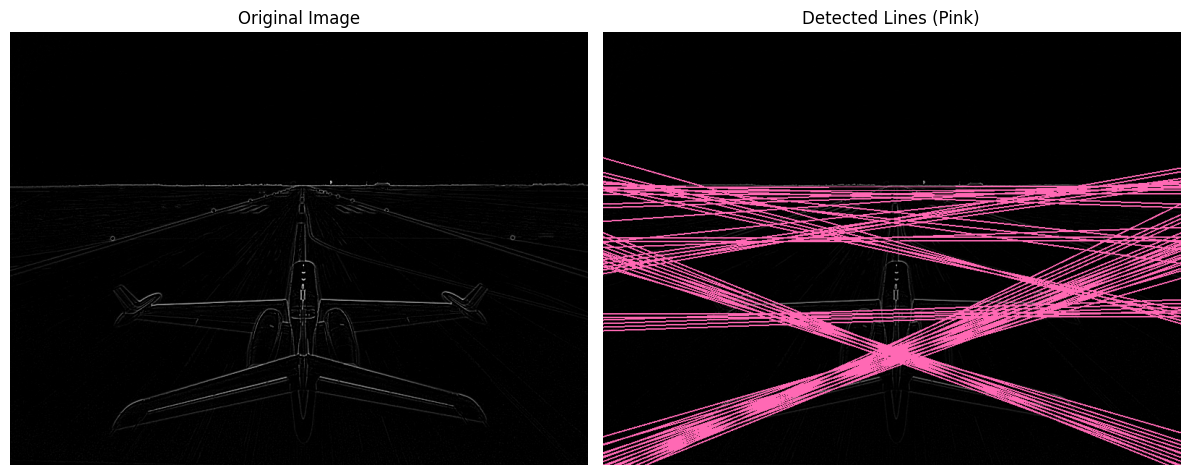

In [14]:
show_comparison("./Paralela-proj3/media/runway.pgm", "./media/output/0.png")

## Memoria Global



In [15]:
!nvcc -arch=sm_75 -o global ./Paralela-proj3/src/globa.cu $(pkg-config --cflags --libs libpng)
!./global ./Paralela-proj3/media/runway.pgm ./media/output/0-global.png

==== CUDA Hough Transform (Global Memory) ====
Input image: ./Paralela-proj3/media/runway.pgm
Output image: ./media/output/0-global.png
Threshold: 2100 votes

Image dimensions: 800 x 600
Edge pixels detected: 138406 (28.83%)

Hough Transform Parameters:
  rMax = 500.00
  rScale = 5.00
  degreeBins = 90
  rBins = 200
  Accumulator size = 18000 bins

CUDA Kernel Configuration:
  Block size: 256 threads
  Grid size: 1875 blocks
  Total threads: 480000

Launching kernel...
Kernel completed!

==== Detected Lines (threshold = 2100 votes) ====
Line 0: theta=110.00 deg (1.9199 rad), r=-155.00, votes=2151
Line 1: theta=106.00 deg (1.8500 rad), r=-150.00, votes=2123
Line 2: theta=108.00 deg (1.8850 rad), r=-150.00, votes=2107
Line 3: theta=110.00 deg (1.9199 rad), r=-150.00, votes=2157
Line 4: theta=112.00 deg (1.9548 rad), r=-150.00, votes=2114
Line 5: theta=70.00 deg (1.2217 rad), r=-145.00, votes=2189
Line 6: theta=72.00 deg (1.2566 rad), r=-145.00, votes=2128
Line 7: theta=108.00 deg (1.8850

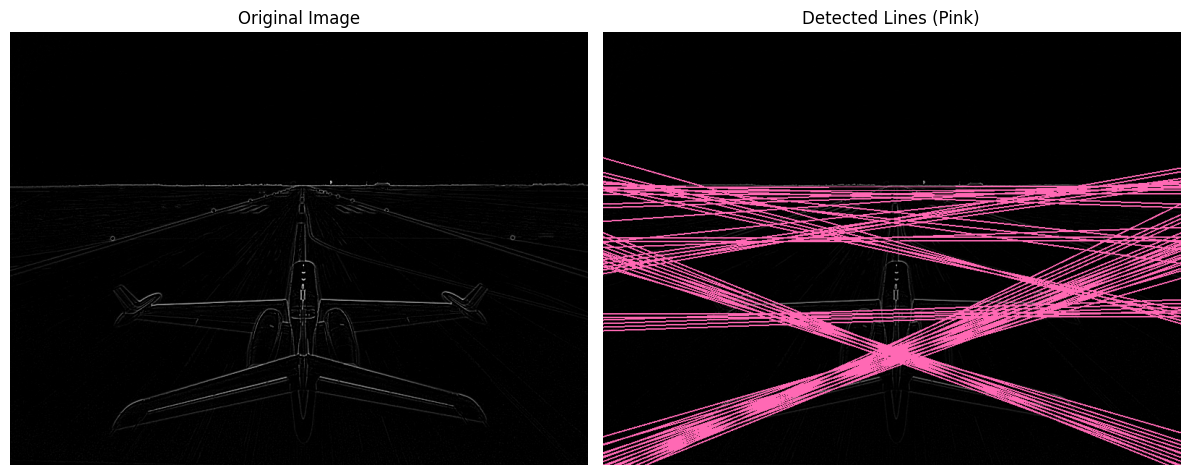

In [16]:
show_comparison("./Paralela-proj3/media/runway.pgm", "./media/output/0-global.png")

## Memoria Constante



In [17]:
!nvcc -arch=sm_75 -o constant ./Paralela-proj3/src/constant.cu $(pkg-config --cflags --libs libpng)
!./constant ./Paralela-proj3/media/runway.pgm ./media/output/0-constant.png

==== CUDA Hough Transform (CONSTANT Memory) ====
Input image: ./Paralela-proj3/media/runway.pgm
Output image: ./media/output/0-constant.png
Threshold: 2100 votes

Image dimensions: 800 x 600
Edge pixels detected: 138406 (28.83%)

Hough Transform Parameters:
  rMax = 500.00
  rScale = 5.00
  degreeBins = 90
  rBins = 200
  Accumulator size = 18000 bins

Memory Configuration:
  Using CONSTANT memory for d_Cos and d_Sin (90 floats each)
  Constant memory used: 720 bytes

CUDA Kernel Configuration:
  Block size: 256 threads
  Grid size: 1875 blocks
  Total threads: 480000

Launching kernel...
Kernel completed!

==== Detected Lines (threshold = 2100 votes) ====
Line 0: theta=110.00 deg (1.9199 rad), r=-155.00, votes=2151
Line 1: theta=106.00 deg (1.8500 rad), r=-150.00, votes=2123
Line 2: theta=108.00 deg (1.8850 rad), r=-150.00, votes=2107
Line 3: theta=110.00 deg (1.9199 rad), r=-150.00, votes=2157
Line 4: theta=112.00 deg (1.9548 rad), r=-150.00, votes=2114
Line 5: theta=70.00 deg (1.221

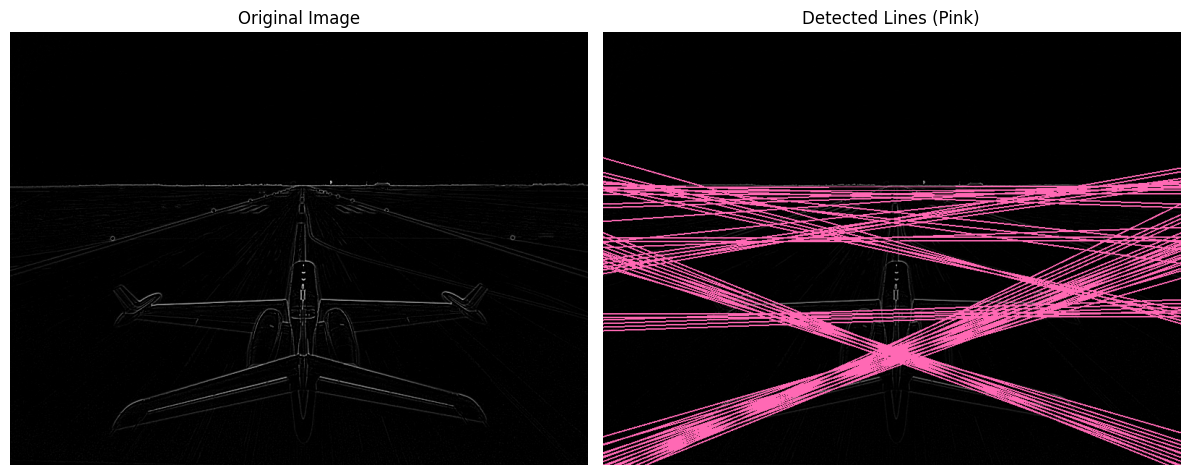

In [18]:
show_comparison("./Paralela-proj3/media/runway.pgm", "./media/output/0-constant.png")